## Feladat rövid ismertetése

![picture](https://drive.google.com/uc?export=view&id=1aCi0iqjl3-a7IsshXoF9Kp8Ufp9D8Diq)


![picture](https://drive.google.com/uc?export=view&id=1eDuB627YP3Yjvv64ScYElU37R2mMWWMZ)

![picture](https://drive.google.com/uc?export=view&id=1_FqRFnbuNfhaAubYNvyiD4KzglBQZuyB)

##Import

In [ ]:
pip install pandas numpy tensorflow scikit-learn

In [ ]:
pip install tensorflow_addons

In [ ]:
pip install -U imbalanced-learn

In [1]:
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import concurrent.futures
import tensorflow as tf

from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, concatenate, BatchNormalization, Activation, LeakyReLU, Multiply, Permute, Reshape, Lambda, RepeatVector
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, make_scorer, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import ADASYN, BorderlineSMOTE, SMOTE
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder
from sklearn.manifold import TSNE
from collections import defaultdict
import unittest
from numpy.testing import assert_array_equal
import ipywidgets as widgets
from IPython.display import display, clear_output


## Adatok

#### Liang Yu és munkatársai által közzétett adatok tensorflow record formátumúak, így először egy parszer segítségével átkonvertálom őket pandas dataframmé.

In [2]:
def parse_tfrecord(example):
    features = {
        'tic_id': tf.io.FixedLenFeature([], tf.int64),
        'row_id': tf.io.FixedLenFeature([], tf.int64),
        'Epoc': tf.io.FixedLenFeature([], tf.float32),
        'Sectors': tf.io.FixedLenFeature([], tf.int64),
        'local_view': tf.io.FixedLenFeature([61], tf.float32),
        'secondary_view': tf.io.FixedLenFeature([61], tf.float32),
        'Transit_Depth': tf.io.FixedLenFeature([], tf.float32),
        'global_view': tf.io.FixedLenFeature([201], tf.float32),
        'Duration': tf.io.FixedLenFeature([], tf.float32),
        'ccd': tf.io.FixedLenFeature([], tf.int64),
        'Period': tf.io.FixedLenFeature([], tf.float32),
        'depth_change': tf.io.FixedLenFeature([], tf.float32),
        'camera': tf.io.FixedLenFeature([], tf.int64),
        'Disposition': tf.io.FixedLenFeature([], tf.string),
    }

    return tf.io.parse_single_example(example, features)

def read_dataset(file_pattern):
    files = tf.io.gfile.glob(file_pattern)
    dataset = tf.data.TFRecordDataset(files)
    return dataset.map(parse_tfrecord)

def dataset_to_dataframe(dataset):
    records = []
    for record in dataset:
        parsed_record = {key: value.numpy() for key, value in record.items()}
        records.append(parsed_record)
    return pd.DataFrame(records)

train_pattern = ['train-0000{}-of-00008'.format(i) for i in range(8)]
test_pattern = 'test-00000-of-00001'
val_pattern = 'val-00000-of-00001'

train_dataset = read_dataset(train_pattern)
test_dataset = read_dataset(test_pattern)
val_dataset = read_dataset(val_pattern)

train_df = dataset_to_dataframe(train_dataset)
test_df = dataset_to_dataframe(test_dataset)
val_df = dataset_to_dataframe(val_dataset)

def decode_bytes(x):
    return x.decode('utf-8')

train_df['Disposition'] = train_df['Disposition'].apply(decode_bytes)
test_df['Disposition'] = test_df['Disposition'].apply(decode_bytes)
val_df['Disposition'] = val_df['Disposition'].apply(decode_bytes)

In [4]:
train_df

,Disposition,Duration,Epoc,Period,Sectors,Transit_Depth,camera,ccd,depth_change,global_view,local_view,row_id,secondary_view,tic_id
0,J,0.018976,1325.519165,0.117514,2,-51882.871094,2,1,0.021858,"[-0.26562434, -0.61626935, -0.5845301, -0.5046...","[0.15251282, 0.34120828, 0.49230614, 0.5015539...",3594,"[-0.6317023, -0.2648961, 0.014789562, -0.08227...",201291168
1,J,0.156284,1357.567749,1.378893,2,-51882.871094,1,2,0.514410,"[1.4579551, 1.581101, 1.124804, 1.2362709, 1.0...","[0.8999962, 0.6396017, 0.61073464, -0.01752643...",5278,"[-0.10018177, 0.028247697, 0.0, 0.16691712, 0....",70775438
2,J,0.363797,1354.612671,0.662148,2,-51882.871094,1,1,0.531969,"[0.43146962, 0.23385176, 0.6106999, 0.60349447...","[0.96172047, 1.0056368, 0.8330003, 0.8792302, ...",5322,"[-0.8480952, -0.6290109, -0.5988463, -0.442735...",76944565
3,J,0.272520,1325.816895,0.739860,2,-51882.871094,4,2,0.064786,"[0.23947957, 0.09840288, 0.07395018, 0.4272265...","[0.28603047, 0.07896457, 0.20502119, 0.1732962...",6729,"[-0.32621714, -0.66402626, -0.77617854, -0.048...",179444779
4,J,0.034525,1354.342773,0.168363,2,-51882.875000,4,2,0.037692,"[-0.7914866, -0.56841093, -0.90398467, -0.4970...","[-0.36739764, -0.2959777, -0.2437606, -0.16561...",1959,"[-0.19288762, -0.09012802, -0.005803698, -0.00...",30631031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13145,J,0.306524,1356.508667,2.431377,2,-51882.875000,3,1,-0.076715,"[0.25040475, 0.1748516, -0.25876957, 0.4646519...","[0.5349816, 0.10783798, 0.0, 0.062072594, 0.20...",1201,"[-0.5099395, -0.2610199, -0.013828868, 0.03111...",160196644
13146,J,0.018647,1325.826538,0.157572,4,-51882.871094,4,3,0.029525,"[-0.8488945, -0.76858133, -0.59189904, -0.4129...","[1.103685, 0.92982835, 0.54336816, 0.52445084,...",11523,"[-0.1820444, -0.18216795, -0.339928, -0.344022...",270471974
13147,J,0.086853,1326.775513,0.652589,4,-51882.875000,4,3,0.020843,"[0.123891085, -0.055945847, 0.07097072, -0.223...","[0.6529525, 0.69058144, 0.80414826, 0.58449507...",8400,"[-1.0, -0.57836837, -0.66402966, -0.7568603, -...",141187719
13148,PC,0.162419,1326.658447,2.166031,1,-51882.871094,4,3,0.016130,"[-0.086693116, -0.07344482, -0.07668034, -0.09...","[0.20690493, 0.08123834, -0.010720634, 0.09892...",5836,"[-0.07755127, -0.2760155, 0.1085413, 0.6567023...",349518800


In [5]:
full_df = pd.concat([train_df, test_df, val_df])

## A transit depth difference adat kiszámítása

#### Először az outlier értékeket szűröm ki (az alsó és felső 1%-ot), hogy majd az átlaggal való osztás ne tegye túl homogénné az értékeket.

In [6]:
def handle_outliers(df, column, lower_quantile=0.01, upper_quantile=0.99):
    """ Cap and floor the outliers based on quantiles """
    lower_bound = df[column].quantile(lower_quantile)
    upper_bound = df[column].quantile(upper_quantile)
    df[column] = np.clip(df[column], lower_bound, upper_bound)
    return df

train_df = handle_outliers(train_df, 'depth_change')
test_df = handle_outliers(test_df, 'depth_change')
val_df = handle_outliers(val_df, 'depth_change')

# Robust Scaler
scaler = RobustScaler()
train_df['transit_depth_difference'] = scaler.fit_transform(train_df[['depth_change']])
test_df['transit_depth_difference'] = scaler.transform(test_df[['depth_change']])
val_df['transit_depth_difference'] = scaler.transform(val_df[['depth_change']])

print("A normalizált minta a Robust Saler alkalmazása után:")
print(train_df[['depth_change', 'transit_depth_difference']].head())

A normalizált minta a Robust Saler alkalmazása után:
   depth_change  transit_depth_difference
0      0.021858                 -0.081420
1      0.514410                  1.567050
2      0.531969                  1.625817
3      0.064786                  0.062252
4      0.037692                 -0.028426


In [7]:
mean_depth_change = train_df['depth_change'].mean()
std_depth_change = train_df['depth_change'].std()

print("Mélységcsökkenés átlaga:", mean_depth_change)
print("Mélységcsökkenés szórása:", std_depth_change)

#normalizálom a mélységcsökkenést (depth_change) úgy, hogy kivonom a tanítóhalmaz átlagát, majd elosztom a tanítóhalmaz szórásával
def normalize_depth_change(df, mean, std):
    if std == 0:
        print("A szórás értéke 0, így a kapott értékek egyenlőek lesznek.")
    else:
        df['transit_depth_difference'] = (df['depth_change'] - mean) / std
    return df

# normalizálom a három adathalmazt a kapott statisztikai értékek alapján
train_df = normalize_depth_change(train_df, mean_depth_change, std_depth_change)
test_df = normalize_depth_change(test_df, mean_depth_change, std_depth_change)
val_df = normalize_depth_change(val_df, mean_depth_change, std_depth_change)


print("A mélységcsökkenés értékének terjedelme a tanítóhalmazban:", train_df['depth_change'].min(), " - ", train_df['depth_change'].max())
print("A mélységcsökkenés eloszlása a tanítóhalmazban:", train_df['depth_change'].var())



Mélységcsökkenés átlaga: 0.414399414314417
Mélységcsökkenés szórása: 1.6747002537167472
A mélységcsökkenés értékének terjedelme a tanítóhalmazban: -5.74492018699646  -  9.97460076332094
A mélységcsökkenés eloszlása a tanítóhalmazban: 2.8046209397989377


## Címkék átírása vetting feladathoz.






In [9]:
train_df.loc[train_df['Disposition'] == 'EB', 'Disposition'] = 'J'
test_df.loc[test_df['Disposition'] == 'EB', 'Disposition'] = 'J'
val_df.loc[val_df['Disposition'] == 'EB', 'Disposition'] = 'J'

## Osztályok eloszlásának vizsgálata

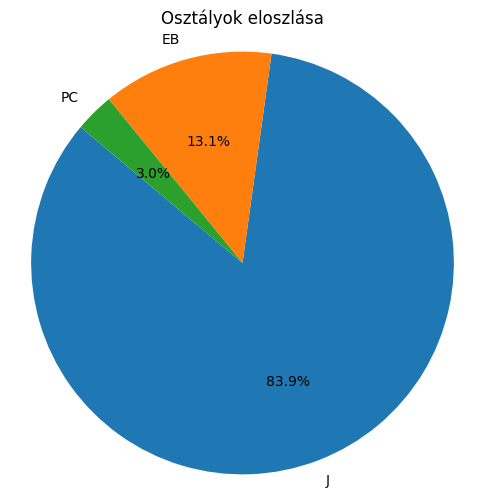

In [10]:
disposition_counts = full_df['Disposition'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(disposition_counts, labels=disposition_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Osztályok eloszlása')
plt.axis('equal')

plt.show()

## A szűrő eljárás a paraméterek és metaparaméterek gyorsabb beállításához. (opcionális)

In [11]:
# szűrő eljárás a lokális és másodlagos nézetekhez
def filter(flux_array):

    classifications = []

    first_segment = flux_array[:20]
    middle_segment = flux_array[20:41]
    third_segment = flux_array[41:]

    first_avg = np.mean(first_segment)
    middle_avg = np.mean(middle_segment)
    third_avg = np.mean(third_segment)

    if first_avg < 0.18 and third_avg < 0.18 and -1 < middle_avg < -0.3:
        classifications.append('PC')
    else:
        classifications.append('Not PC')

    return np.array(classifications)

# szűrő eljárás a globális nézetekhez
def filter_global(flux_array):

    classifications = []

    first_segment = flux_array[:98]
    middle_segment = flux_array[98:102]
    third_segment = flux_array[102:]

    first_avg = np.mean(first_segment)
    middle_avg = np.mean(middle_segment)
    third_avg = np.mean(third_segment)

    if first_avg < 0.05 and third_avg < 0.05 and -1 < middle_avg < -0.2:
        classifications.append('PC')
    else:
        classifications.append('Not PC')

    return np.array(classifications)


def filter_data(df):
    pc_count = 0
    eb_count = 0
    j_count = 0
    indices = []

    for index, row in df.iterrows():
        if filter(row['local_view']) == "PC":
            if filter(row['secondary_view']) != "PC":
                if filter_global(row['global_view']) == "PC":
                    indices.append(index)
                    if row["Disposition"] == "EB":
                        eb_count += 1
                    elif row["Disposition"] == "J":
                        j_count += 1
                    elif row["Disposition"] == "PC":
                        pc_count += 1

    print(f"PC count: {pc_count}")
    print(f"EB count: {eb_count}")
    print(f"J count: {j_count}")
    return indices


train_indices = filter_data(train_df)
train_df = train_df.loc[train_indices]

test_indices = filter_data(test_df)
test_df = test_df.loc[test_indices]

val_indices = filter_data(val_df)
val_df = val_df.loc[val_indices]

PC count: 364
EB count: 0
J count: 3310
PC count: 48
EB count: 0
J count: 437
PC count: 46
EB count: 0
J count: 361


## A modell

![picture](https://drive.google.com/uc?export=view&id=1BJ1J1cZS_t8B8JW_nKhyE3W6v0l74lQ0)


#Tanítás

In [12]:
# A kiegyensúlyozott batch generálás
class BalancedBatchGenerator:
    def __init__(self, X, y, batch_size=32, classes=None):
        self.X = [X[i] for i in range(len(X))]
        self.y = y
        self.batch_size = batch_size
        self.classes = np.unique(y.argmax(axis=1)) if classes is None else classes
        self.class_indices = {cls: np.where(y.argmax(axis=1) == cls)[0] for cls in self.classes}

    def generate(self):
        while True:
            batch_indices = []
            per_class = self.batch_size // len(self.classes)

            for cls in self.classes:
                choices = np.random.choice(self.class_indices[cls], per_class, replace=True)
                batch_indices.extend(choices)

            if len(batch_indices) < self.batch_size:
                remainder = self.batch_size - len(batch_indices)
                additional_indices = np.random.choice(np.concatenate(list(self.class_indices.values())), remainder, replace=True)
                batch_indices.extend(additional_indices)

            np.random.shuffle(batch_indices)
            yield [self.X[i][batch_indices] for i in range(len(self.X))], self.y[batch_indices]


def tensor_to_value(tensor):
    return tensor.numpy().decode('utf-8') if isinstance(tensor, tf.Tensor) else tensor

for df in [train_df, test_df, val_df]:
    df['Disposition'] = df['Disposition'].apply(tensor_to_value)

# Enkódolom a címkéket (One-hot encoding)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['Disposition'])
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(label_encoder.transform(test_df['Disposition']))
y_val_encoded = to_categorical(label_encoder.transform(val_df['Disposition']))


# Adataugmentációk:
def warp_light_curve(light_curve, warp_factor=0.1):
    length = len(light_curve)
    warp_size = int(warp_factor * length)
    start = np.random.randint(0, length - warp_size)
    end = start + warp_size

    # Kiválasztom az elnyújtani kívánt szegmenst
    segment = light_curve[start:end]

    # Meghatározom véletlenszerűen a megnyújtás mértékét
    if np.random.rand() > 0.5:
        # Kompresszió
        new_size = np.random.randint(low=warp_size // 2, high=warp_size)
    else:
        # Nyújtás
        new_size = np.random.randint(low=warp_size, high=min(length, warp_size * 2))
        if start + new_size > length:
            new_size = length - start  # Az új hossz nem haladhatja meg a fénygörbe eredeti hosszát

    # Interpoláció
    warped_segment = np.interp(
        np.linspace(0, warp_size, num=new_size, endpoint=False),
        np.arange(warp_size),
        segment
    )

    # Új fénygörbe létrehozása
    new_light_curve = np.concatenate([
        light_curve[:start],
        warped_segment,
        light_curve[start + warp_size:]
    ])

    # Fénygörbe hosszának igazítása
    if len(new_light_curve) > length:
        new_light_curve = new_light_curve[:length]
    elif len(new_light_curve) < length:
        new_light_curve = np.pad(new_light_curve, (0, length - len(new_light_curve)), 'constant')

    return new_light_curve


# Készítettem két másik adataugmentációt is azonban ezekkel egyenlőre nem sikerült jobb eredményeket elérnem, így a kiértékelésnél nem használtam
def jitter_light_curve(light_curve, noise_level=0.02):
    # Gauss zajjal történő adatagmentáció
    noise = np.random.normal(0, noise_level, size=len(light_curve))
    return light_curve + noise

def randomly_shift_points(series, num_points=61, max_shift=0.2):
    # Véletlenszerűen választott adatpontok függőleges irányban történő eltolása. A mérésekkor fellépő zajt szeretném szimulálni.
    modified_series = np.copy(series)

    indices_to_shift = np.random.choice(len(series), size=num_points, replace=False)

    shifts = np.random.uniform(-max_shift, max_shift, size=num_points)

    for idx, shift in zip(indices_to_shift, shifts):
        modified_series[idx] += shift

    return modified_series


def augment_light_curves(df, features, warp_factor=0.08):
    augmented_rows = []

    for _, row in df.iterrows():
        # Liang Yu és munkatársai által használt adataugmentáció, vízszintes tükrözés
        flip_augmented_row = row.copy()
        for feature in features:
            if np.random.rand() < 0.5:
                flip_augmented_row[feature] = np.flip(row[feature], axis=0).tolist()
        augmented_rows.append(flip_augmented_row)

        # A dolgozatomban emltített másik adataugmentációm, a szeletek nyújtása
        warp_augmented_row = row.copy()
        for feature in features:
          if np.random.rand() < 0.5:
            light_curve = np.array(row[feature])
            warped_light_curve = warp_light_curve(light_curve, warp_factor=warp_factor)
            warp_augmented_row[feature] = warped_light_curve.tolist()
        augmented_rows.append(warp_augmented_row)


    augmented_df = pd.DataFrame(augmented_rows)
    return pd.concat([df, augmented_df], ignore_index=True)

# A globális, lokális és másodlagos nézeteket is augmentálom
features_to_augment = ['global_view', 'local_view', 'secondary_view']

# Adataugmentáció alkalmazása a tanítóhalmazra
augmented_train_df = augment_light_curves(train_df, features_to_augment)
augmented_train_df = augmented_train_df.sample(frac=1).reset_index(drop=True)
y_train_encoded = to_categorical(label_encoder.transform(augmented_train_df['Disposition']))


# Input adatok előkészítése
def prepare_data(df):
    X_global = np.array(df['global_view'].tolist()).reshape((-1, 201, 1))
    X_local = np.array(df['local_view'].tolist()).reshape((-1, 61, 1))
    X_secondary = np.array(df['secondary_view'].tolist()).reshape((-1, 61, 1))
    X_depth_change = np.array((df['transit_depth_difference'] * 4).tolist()).reshape((-1, 1)) # a dolgozatban említett módon a "transit_depth_difference" értéket néggyel szorzom
    return X_global, X_local, X_secondary, X_depth_change

X_global_train, X_local_train, X_secondary_train, X_depth_change_train = prepare_data(augmented_train_df)
X_global_test, X_local_test, X_secondary_test, X_depth_change_test = prepare_data(test_df)
X_global_val, X_local_val, X_secondary_val, X_depth_change_val = prepare_data(val_df)


# Konvolúciós neurális hálózat

# Az első CNN ágam, amelyet a lokális és másodlagos nézeteknél használok
def create_cnn_branch(input_shape):
    input_layer = Input(shape=input_shape)
    # Első konvolúciós réteg
    x = Conv1D(16, 5, padding='same', kernel_regularizer=l2(0.001))(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.2)(x)
    # Második konvolúciós réteg
    x = Conv1D(32, 5, padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.3)(x)
    # Harmadik konvolúciós réteg
    x = Conv1D(64, 5, padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    return input_layer, x

# A másik, mélyebb ágam a globális nézethez
def create_cnn_branch_deep(input_shape):
    input_layer = Input(shape=input_shape)
    # Első konvolúciós réteg
    x = Conv1D(32, 5, padding='same', kernel_regularizer=l2(0.001))(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.3)(x)
    # Második konvolúciós réteg
    x = Conv1D(128, 5, padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.4)(x)
    # Harmadik konvolúciós réteg
    x = Conv1D(128, 5, padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.4)(x)
    # Negyedik konvolúciós réteg
    x = Conv1D(256, 5, padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    return input_layer, x

# A tanulási ráta szabályozására használt egyszerű scheduler
def scheduler(epoch, lr):
  if epoch < 2:
      return lr
  else:
      return lr * tf.math.exp(-0.1)


local_input, local_features = create_cnn_branch((61, 1))
global_input, global_features = create_cnn_branch_deep((201, 1))
secondary_input, secondary_features = create_cnn_branch((61, 1))

depth_change_input = Input(shape=(1,))

# Egyesítem a jellemzőket, itt kerül elő a "transit_depth_difference" is
combined_features = concatenate([local_features, global_features, secondary_features, depth_change_input])

# Teljesen összekötött rétegek
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(combined_features)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
output = Dense(y_train_encoded.shape[1], activation='softmax')(x)


# A modell
model = Model(inputs=[local_input, global_input, secondary_input, depth_change_input], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Korai megállás
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1),
    LearningRateScheduler(scheduler, verbose=1)
]

# A kiegyensúlyozatlanság miatt bevezetett súlyok, azonban végül nem segítettek a tanítás során így nem használtam. Fenntartom a lehetőségét,
# hogy további finomhangolások után segíthetnek a modell eredményességében, így egyenlőre megtartottam a kódrészletet.
y_train_labels = np.argmax(y_train_encoded, axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Kiegyensúlyozott batch generálás
batch_size = 75
generator = BalancedBatchGenerator([X_local_train, X_global_train, X_secondary_train, X_depth_change_train], y_train_encoded, batch_size=batch_size)
validation_data = ([X_local_val, X_global_val, X_secondary_val, X_depth_change_val], y_val_encoded)

# Modell tanítása
history = model.fit(
    generator.generate(),
    steps_per_epoch=len(y_train_encoded) // batch_size,
    validation_data=validation_data,
    epochs=30,
    callbacks=callbacks
)

predictions = model.predict([X_local_test, X_global_test, X_secondary_test, X_depth_change_test])
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test_encoded, axis=1)

# Modell kiértékelése
results = model.evaluate([X_local_test, X_global_test, X_secondary_test, X_depth_change_test], y_test_encoded)
print(f'Test Accuracy: {results[1]*100:.2f}%')

report = classification_report(true_classes, predicted_classes, target_names=label_encoder.classes_)
print(report)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/30
146/146 [==============================] - ETA: 0s - loss: 1.6824 - accuracy: 0.7027
Epoch 1: val_loss improved from inf to 1.29350, saving model to best_model.h5
146/146 [==============================] - 45s 256ms/step - loss: 1.6824 - accuracy: 0.7027 - val_loss: 1.2935 - val_accuracy: 0.8870 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


146/146 [==============================] - ETA: 0s - loss: 1.2808 - accuracy: 0.8015
Epoch 2: val_loss improved from 1.29350 to 1.02486, saving model to best_model.h5
146/146 [==============================] - 34s 236ms/step - loss: 1.2808 - accuracy: 0.8015 - val_loss: 1.0249 - val_accuracy: 0.8845 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0009048374486155808.
Epoch 3/30
146/146 [==============================] - ETA: 0s - loss: 1.0429 - accuracy: 0.8323
Epoch 3: val_loss improved from 1.02486 to 0.91851, saving model to best_model.h5
146/146 [==============================] - 36s 247ms/step - loss: 1.0429 - accuracy: 0.8323 - val_loss: 0.9185 - val_accuracy: 0.8231 - lr: 9.0484e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0008187307976186275.
Epoch 4/30
146/146 [==============================] - ETA: 0s - loss: 0.8827 - accuracy: 0.8530
Epoch 4: val_loss improved from 0.91851 to 0.80449, saving model to best_model.h5
146/146 [==========

## Precision-Recall görbe

### Egy modell kiértékeléséhez

16/16 [==============================] - 1s 42ms/step


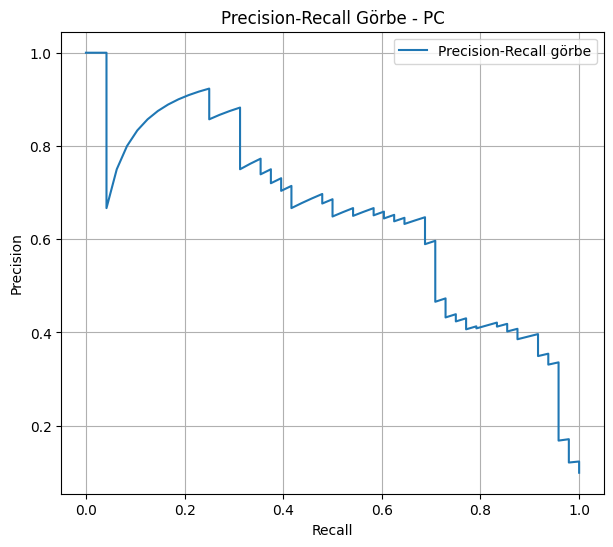

In [22]:
y_test = np.argmax(y_test_encoded, axis=1)
class_of_interest = 1  # itt állíthatjuk be, hogy melyik osztályra szeretnénk kirajzolni a precision-recall görbét (jelen esetben a 0 a J osztályt, az 1 pedig a PC osztályt reprezentálja)
y_test_binary = (y_test == class_of_interest).astype(int)

# Valószínűségek összegyűjtése.
probabilities = model.predict([X_local_test, X_global_test, X_secondary_test, X_depth_change_test])
class_probabilities = probabilities[:, class_of_interest]

precision, recall, thresholds = precision_recall_curve(y_test_binary, class_probabilities)

# Görbe irajzolása
plt.figure(figsize=(7, 6))
plt.plot(recall, precision, label='Precision-Recall görbe')
plt.title('Precision-Recall Görbe - {}'.format(label_encoder.classes_[class_of_interest]))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

### Több modell átlagolt kiértékeléséhez

In [ ]:
def predict_with_models(model_files, X_inputs):
    predictions = []
    for model_file in model_files:
        model = load_model(model_file)
        predictions.append(model.predict(X_inputs))

    # Átlagoljuk a predikciókat.
    predictions = np.array(predictions)
    mean_predictions = np.mean(predictions, axis=0)
    return mean_predictions


def plot_precision_recall_curve(y_test_encoded, mean_predictions, class_of_interest, class_labels):
    y_test = np.argmax(y_test_encoded, axis=1)
    y_test_binary = (y_test == class_of_interest).astype(int)

    class_probabilities = mean_predictions[:, class_of_interest]

    precision, recall, thresholds = precision_recall_curve(y_test_binary, class_probabilities)

    # Precision-recall görbe kirajolása
    plt.figure(figsize=(7, 6))
    plt.title('Precision-Recall görbe - PC osztály'.format(class_labels[class_of_interest]))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)
    plt.show()

# A modellek fájlneveinek listája
model_files = [f'model_{i}.h5' for i in range(1, 8)]

mean_predictions = predict_with_models(model_files, [X_local_test, X_global_test, X_secondary_test, X_depth_change_test])
plot_precision_recall_curve(y_test_encoded, mean_predictions, 1, label_encoder.classes_)

In [ ]:
# modell mentése
model.save('model_1.h5')

In [ ]:
model_path = 'model_1.h5'
# Korábbi modell betöltése
model = load_model(model_path)

## t-SNE

Miért nem használhatunk egyszerűen SMOTE-ot a kiegyensúlyozatlanság kezelésére?

![picture](https://drive.google.com/uc?export=view&id=1f0AKk7d5ONvPr3viDyQGrrdIVVrcUnZG)


In [34]:
def prepare_data(df):
    X_global = np.stack(df['global_view'].apply(np.array).to_numpy())
    X_local = np.stack(df['local_view'].apply(np.array).to_numpy())
    X_secondary = np.stack(df['secondary_view'].apply(np.array).to_numpy())

    X_combined = np.hstack((X_global, X_local, X_secondary))
    return X_combined

X = prepare_data(full_df)
y_labels = full_df['Disposition'].values

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_labels)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


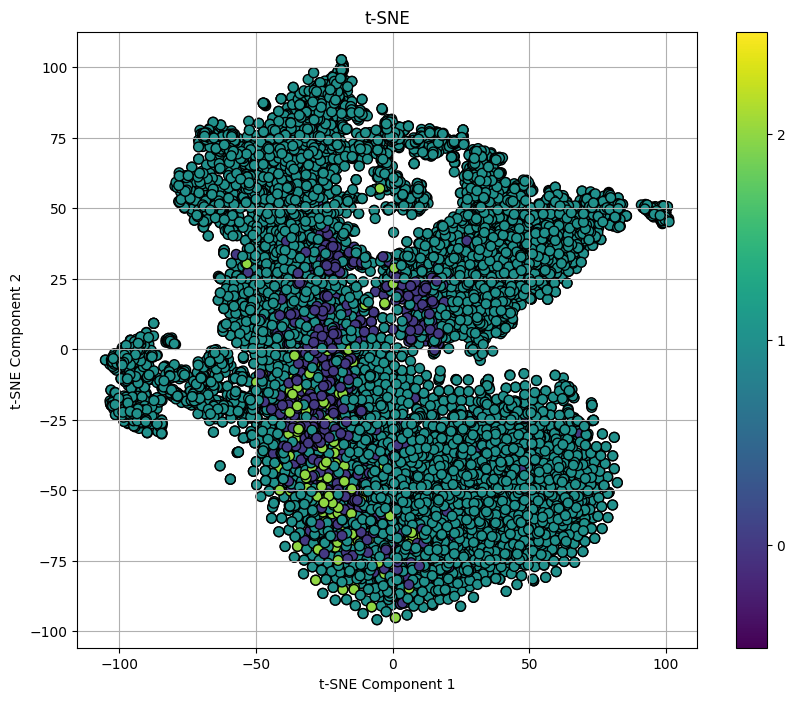

In [36]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=3000)
X_tsne = tsne.fit_transform(X_scaled)

def plot_tsne(X, y, title):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', s=50)
    plt.title(title)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.colorbar(scatter, ticks=range(len(np.unique(y))))
    plt.clim(-0.5, len(np.unique(y)) - 0.5)
    plt.grid(True)
    plt.show()

plot_tsne(X_tsne, y, 't-SNE')


A t-SNE diagrammon jól látható, hogy a példák nagyon nehezen szeparálhatóak, egy SMOTE nem tudja megfelelően reprezentálni a PC sztályt, látható, hogy egy egyszerű interpoláció könnyedén téves példákat hoz létre. (az ábrán a 2-es a PC, a 1-es a J a 0 pedig az EB osztályokba eső pontok)

## Adataugmentáció

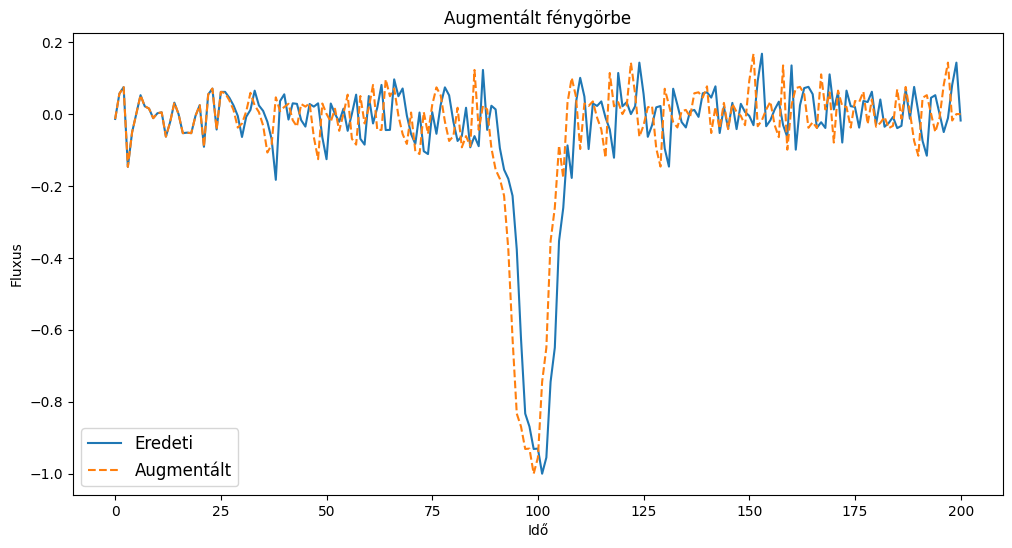

In [39]:
def warp_light_curve(light_curve, warp_factor=0.1):
    length = len(light_curve)
    warp_size = int(warp_factor * length)
    start = np.random.randint(0, length - warp_size)
    end = start + warp_size

    # Kiválasztom az elnyújtani/összenyomni kívánt szegmenst
    segment = light_curve[start:end]

    # Meghatározom véletlenszerűen a megnyújtás/összenyomás mértékét
    if np.random.rand() > 0.5:
        # Kompresszió
        new_size = np.random.randint(low=warp_size // 2, high=warp_size)
    else:
        # Nyújtás
        new_size = np.random.randint(low=warp_size, high=min(length, warp_size * 2))
        if start + new_size > length:
            new_size = length - start  # Az új hossz nem haladhatja meg a fénygörbe eredeti hosszát

    # Interpoláció
    warped_segment = np.interp(
        np.linspace(0, warp_size, num=new_size, endpoint=False),
        np.arange(warp_size),
        segment
    )

    # Új fénygörbe létrehozása
    new_light_curve = np.concatenate([
        light_curve[:start],
        warped_segment,
        light_curve[start + warp_size:]
    ])

    # Fénygörbe hosszának igazítása
    if len(new_light_curve) > length:
        new_light_curve = new_light_curve[:length]
    elif len(new_light_curve) < length:
        new_light_curve = np.pad(new_light_curve, (0, length - len(new_light_curve)), 'constant')

    return new_light_curve


flux_array = train_df["global_view"][11940]

# Szintetikus fénygörbe/idősor generálás
synthetic_flux_array = warp_light_curve(flux_array)

# Az eredeti és az augmentált fénygörbe kirajzolása
plt.figure(figsize=(12, 6))
plt.plot(flux_array, label='Eredeti')
plt.plot(synthetic_flux_array, label='Augmentált', linestyle='--')
plt.title('Augmentált fénygörbe')
plt.xlabel('Idő')
plt.ylabel('Fluxus')

# Place the legend in the bottom left corner with a large font size
plt.legend(loc='lower left', fontsize='large')
plt.show()

## Keresztvalidáció

In [ ]:
class BalancedBatchGenerator:
    def __init__(self, X, y, batch_size=32, classes=None):
        self.X = [X[i] for i in range(len(X))]
        self.y = y
        self.batch_size = batch_size
        self.classes = np.unique(y.argmax(axis=1)) if classes is None else classes
        self.class_indices = {cls: np.where(y.argmax(axis=1) == cls)[0] for cls in self.classes}

    def generate(self):
        while True:
            batch_indices = []
            per_class = self.batch_size // len(self.classes)

            for cls in self.classes:
                choices = np.random.choice(self.class_indices[cls], per_class, replace=True)
                batch_indices.extend(choices)

            if len(batch_indices) < self.batch_size:
                remainder = self.batch_size - len(batch_indices)
                additional_indices = np.random.choice(np.concatenate(list(self.class_indices.values())), remainder, replace=True)
                batch_indices.extend(additional_indices)

            np.random.shuffle(batch_indices)
            yield [self.X[i][batch_indices] for i in range(len(self.X))], self.y[batch_indices]

# Tanító- és validációshalmaz egyesítése
all_train_df = pd.concat([train_df, val_df], ignore_index=True)

# Címkénk enkódolása (one-hot)
label_encoder = LabelEncoder()
all_labels = label_encoder.fit_transform(all_train_df['Disposition'])
all_labels_encoded = to_categorical(all_labels)

def create_model():
    local_input, local_features = create_cnn_branch((61, 1))
    global_input, global_features = create_cnn_branch_deep((201, 1))
    secondary_input, secondary_features = create_cnn_branch((61, 1))
    depth_change_input = Input(shape=(1,))

    combined_features = concatenate([local_features, global_features, secondary_features, depth_change_input])

    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(combined_features)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    output = Dense(Y_all.shape[1], activation='softmax')(x)

    model = Model(inputs=[local_input, global_input, secondary_input, depth_change_input], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

def augment_light_curves(df, features, warp_factor=0.08):
    augmented_rows = []
    for _, row in df.iterrows():
        flip_augmented_row = row.copy()
        for feature in features:
            if np.random.rand() < 0.5:
                flip_augmented_row[feature] = np.flip(row[feature], axis=0).tolist()
        augmented_rows.append(flip_augmented_row)

        warp_augmented_row = row.copy()
        for feature in features:
          if np.random.rand() < 0.5:
            light_curve = np.array(row[feature])
            warped_light_curve = warp_light_curve(light_curve, warp_factor=warp_factor)
            warp_augmented_row[feature] = warped_light_curve.tolist()
        augmented_rows.append(warp_augmented_row)

    augmented_df = pd.DataFrame(augmented_rows)
    return pd.concat([df, augmented_df], ignore_index=True)


def prepare_data(df):
    X_global = np.array(df['global_view'].tolist()).reshape((-1, 201, 1))
    X_local = np.array(df['local_view'].tolist()).reshape((-1, 61, 1))
    X_secondary = np.array(df['secondary_view'].tolist()).reshape((-1, 61, 1))
    X_depth_change = np.array((df['transit_depth_difference'] * 4).tolist()).reshape((-1, 1))
    return [X_local, X_global, X_secondary, X_depth_change]

features_to_augment = ['global_view', 'local_view', 'secondary_view']
augmented_train_df = augment_light_curves(all_train_df, features_to_augment)
X_all = prepare_data(augmented_train_df)
Y_all = to_categorical(label_encoder.transform(augmented_train_df['Disposition']))

X_test = prepare_data(test_df)
Y_test = to_categorical(label_encoder.transform(test_df['Disposition']))

kf = KFold(n_splits=5, shuffle=True, random_state=42)


for fold_no, (train_index, val_index) in enumerate(kf.split(X_all[0])):
    X_train, X_val = [x[train_index] for x in X_all], [x[val_index] for x in X_all]
    y_train, y_val = Y_all[train_index], Y_all[val_index]

    assert max(train_index) < len(Y_all), "Train index out of bounds"
    assert max(val_index) < len(Y_all), "Validation index out of bounds"

    callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1),
    LearningRateScheduler(scheduler, verbose=1)
    ]

    model = create_model()
    print(f'Training fold {fold_no + 1}...')
    batch_size = 75
    generator = BalancedBatchGenerator([X_local_train, X_global_train, X_secondary_train, X_depth_change_train], y_train_encoded, batch_size=batch_size)
    validation_data = ([X_local_val, X_global_val, X_secondary_val, X_depth_change_val], y_val_encoded)

    history = model.fit(
        generator.generate(),
        steps_per_epoch=len(y_train_encoded) // batch_size,
        validation_data=validation_data,
        epochs=30,
        callbacks=callbacks
    )

    # Mentsük el a modellt
    model.save(f'model_fold_{fold_no+1}.h5')


results = model.evaluate(X_test, Y_test)
print(f'Test Accuracy: {results[1]*100:.2f}%')

predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(Y_test, axis=1)
report = classification_report(true_classes, predicted_classes, target_names=label_encoder.classes_)
print(report)


## Data leakage!
Ha a Liang Yu és munkatársai által közzétett adathalmazt megvizsgáljuk, akkor észrevehetjük, hogy adatszivárgás történt. A teszthalmazban 100 olyan elem szerepel, ami megtalálható a tanítóhalmazban is. Egyébként a validációshalmazzal is van átfedés, ami szintén nem előnyös, azonban kevésbé kritikus, mint az előbb említett.

In [28]:
train_df['local_view_tuple'] = train_df['local_view'].apply(tuple)
test_df['local_view_tuple'] = test_df['local_view'].apply(tuple)

train_views_set = set(train_df['local_view_tuple'])

count = test_df['local_view_tuple'].apply(lambda x: x in train_views_set).sum()

print(f"Átfedések száma: {count}")

Átfedések száma: 100


## GUI

In [23]:
full_df['Disposition'] = full_df['Disposition'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

tic_id_input = widgets.Combobox(
    placeholder='Choose a TIC ID',
    options=[str(id) for id in full_df['tic_id'].unique()],
    description='TIC ID:',
    ensure_option=True,
    disabled=False
)

view_dropdown = widgets.Dropdown(
    options=['global_view', 'local_view', 'secondary_view'],
    value='global_view',
    description='View:',
    disabled=False,
)

submit_button = widgets.Button(
    description='Plot Data'
)

output = widgets.Output()

def on_button_clicked(b):
    with output:
        clear_output(wait=True)
        try:
            tic_id = int(tic_id_input.value.strip())
        except ValueError:
            print("Invalid TIC ID format. Please input a valid number.")
            return

        view = view_dropdown.value
        data = full_df[full_df['tic_id'] == tic_id]

        if not data.empty:
            data_view = data[view].iloc[0]

            if isinstance(data_view, (list, np.ndarray)):
                plt.figure(figsize=(10, 6))
                plt.plot(data_view)
                plt.title(f"{view.capitalize()} -- TIC ID {tic_id} -- Disposition: {data['Disposition'].iloc[0]}")
                plt.show()
            else:
                print("Data format not suitable for plotting. Please check data structure.")
        else:
            print("No data found for this TIC ID")

submit_button.on_click(on_button_clicked)

display(tic_id_input, view_dropdown, submit_button, output)


Combobox(value='', description='TIC ID:', ensure_option=True, options=('201291168', '70775438', '76944565', '1…

Dropdown(description='View:', options=('global_view', 'local_view', 'secondary_view'), value='global_view')

Button(description='Plot Data', style=ButtonStyle())

Output()

## Tesztek

In [24]:
class TestDataAugmentation(unittest.TestCase):

    def setUp(self):
        self.light_curve = np.linspace(0, 1, 100)

    def test_warp_light_curve_length(self):
        warped = warp_light_curve(self.light_curve, warp_factor=0.1)
        self.assertEqual(len(warped), 100)

    def test_jitter_light_curve_noise_level(self):
        jittered = jitter_light_curve(self.light_curve, noise_level=0.02)
        self.assertEqual(len(jittered), 100)
        # Nézzük meg, hogy a zaj mértéke megfelel-e a megszabott korlátoknak.
        mean_noise = np.mean(jittered - self.light_curve)
        self.assertTrue(abs(mean_noise) < 0.02)

    def test_randomly_shift_points_modifications(self):
        shifted = randomly_shift_points(self.light_curve, num_points=20, max_shift=0.1)
        self.assertEqual(len(shifted), 100)
        # Nézzük meg, hogy tényleg shifteltük-e a pontokat
        differences = shifted != self.light_curve
        self.assertEqual(np.sum(differences), 20)

if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)


...
----------------------------------------------------------------------
Ran 3 tests in 0.008s

OK


In [25]:
class BalancedBatchGenerator:
    def __init__(self, X, y, batch_size=32, classes=None):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.classes = np.unique(y.argmax(axis=1)) if classes is None else classes
        self.class_indices = {cls: np.where(y.argmax(axis=1) == cls)[0] for cls in self.classes}

    def generate(self):
        while True:
            batch_indices = []
            per_class = self.batch_size // len(self.classes)

            for cls in self.classes:
                choices = np.random.choice(self.class_indices[cls], per_class, replace=True)
                batch_indices.extend(choices)

            if len(batch_indices) < self.batch_size:
                remainder = self.batch_size - len(batch_indices)
                additional_indices = np.random.choice(np.concatenate(list(self.class_indices.values())), remainder, replace=True)
                batch_indices.extend(additional_indices)

            np.random.shuffle(batch_indices)
            yield self.X[batch_indices], self.y[batch_indices]


In [26]:
class TestBalancedBatchGenerator(unittest.TestCase):

    def setUp(self):
        self.X = np.random.rand(100, 10)
        self.y = np.zeros((100, 3))
        self.y[np.arange(100), np.random.randint(0, 3, size=100)] = 1

    def test_initialization(self):
        generator = BalancedBatchGenerator(self.X, self.y, batch_size=32)
        self.assertEqual(generator.batch_size, 32)
        self.assertTrue(isinstance(generator.class_indices, dict))
        self.assertEqual(len(generator.classes), 3)

    def test_batch_generation(self):
        generator = BalancedBatchGenerator(self.X, self.y, batch_size=32)
        batch_x, batch_y = next(generator.generate())
        self.assertEqual(batch_x.shape, (32, 10))
        self.assertEqual(batch_y.shape, (32, 3))

    def test_class_balance(self):
        generator = BalancedBatchGenerator(self.X, self.y, batch_size=30)
        _, batch_y = next(generator.generate())
        classes, counts = np.unique(np.argmax(batch_y, axis=1), return_counts=True)
        self.assertTrue(np.all(counts - 10 <= 1))

    def test_edge_case_batch_size_not_divisible(self):
        generator = BalancedBatchGenerator(self.X, self.y, batch_size=31)
        _, batch_y = next(generator.generate())
        total_classes = len(generator.classes)
        _, counts = np.unique(np.argmax(batch_y, axis=1), return_counts=True)
        self.assertTrue(all(count >= 31 // total_classes for count in counts))

if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)


.......
----------------------------------------------------------------------
Ran 7 tests in 0.025s

OK


In [27]:
def create_model():
    local_input, local_features = create_cnn_branch((61, 1))
    global_input, global_features = create_cnn_branch_deep((201, 1))
    secondary_input, secondary_features = create_cnn_branch((61, 1))
    depth_change_input = Input(shape=(1,))

    combined_features = concatenate([local_features, global_features, secondary_features, depth_change_input])

    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(combined_features)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    output = Dense(Y_all.shape[1], activation='softmax')(x)

    model = Model(inputs=[local_input, global_input, secondary_input, depth_change_input], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [28]:
expected_local_features_shape = 448
expected_global_features_shape = 3072
expected_secondary_features_shape = 448

class TestModelArchitecture(unittest.TestCase):

    def test_cnn_branches(self):
        local_input, local_features = create_cnn_branch((61, 1))
        global_input, global_features = create_cnn_branch_deep((201, 1))
        secondary_input, secondary_features = create_cnn_branch((61, 1))

        self.assertEqual(local_features.shape[1], expected_local_features_shape)
        self.assertEqual(global_features.shape[1], expected_global_features_shape)
        self.assertEqual(secondary_features.shape[1], expected_secondary_features_shape)

if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)


........
----------------------------------------------------------------------
Ran 8 tests in 0.569s

OK
